# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, we are going to build the convolution neural network to detect the "Traffic Sign". We are using "[German Traffic Sign DataSet](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)" for trainning neural network.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'DataSet/train.p'
validation_file='DataSet/valid.p'
testing_file = 'DataSet/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

### Basic Summary of the Data Set Using Python, Numpy

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape            =", image_shape)
print("Number of classes           =", n_classes)

Number of training examples = 34799
Number of testing examples  = 12630
Image data shape            = (32, 32, 3)
Number of classes           = 43


### Exploratory visualization of the dataset

* Visualizing the distribution of data by plotting output classes against the total number of data present in that class 

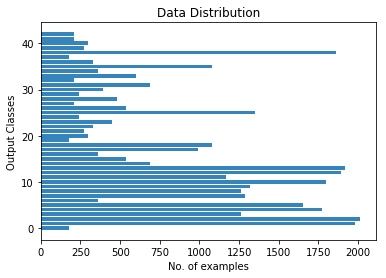

In [3]:
# Reading the class name from .csv files
import csv
SignNames=[]
with open('signnames.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        SignNames.append(row[1])

# Calculating the data distribution
from collections import Counter
Output_Dense=Counter(y_train)

# Plot the Histogram
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_axis=[]
y_axis=[]

for i in range(n_classes):
    #x_axis.append(SignNames[i+1])
    y_axis.append(i)
    x_axis.append(Output_Dense[i])

plt.barh(y_axis, x_axis, align='center', alpha=0.9)
plt.title("Data Distribution")
plt.xlabel("No. of examples")
plt.ylabel("Output Classes")

> From the above plot, It is clear that the output classes are not equally distributed in the training data set.

> ***Solution*** : By performing `Data Augumentation` (example : rotating imgae, changing brightness), we can achieve equal distribution

- Viewing the image and understanding the relationship with the output class

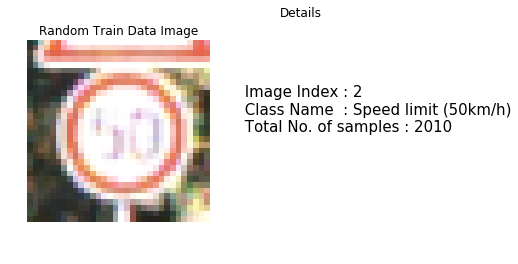

In [4]:
# Viewing the image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

fig,ax=plt.subplots(nrows=1,ncols=2,gridspec_kw={'width_ratios':[3,2]})
ax[0].imshow(image, cmap="gray")
ax[0].axis('off')
ax[0].set_title("Random Train Data Image")

desc=     " Image Index : "+str(y_train[index])+"\n"
desc=desc+" Class Name  : "+SignNames[y_train[index]+1]+"\n"
desc=desc+" Total No. of samples : "+str(Output_Dense[y_train[index]])
ax[1].text(0,0.5,desc,fontsize=15)
ax[1].axis('off')
ax[1].set_title("Details")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

Since the images are taken in different environment, We are `Pre-process` our data set before feeding into neural network. In this project, The below two pre-processing technique is followed. 
> 1. Normalization
>>By performing normalization, we can achieve zero mean and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 
> 2. RGB to Gray
>> By reducting the color channel, we can reduce the computational cost and increase the accuracy in detecting the shape rather than color.

In [5]:
def preprocesssing(inp):
    # Gray Scale Conversion
    r,g,b=inp[:,:,:,0],inp[:,:,:,1],inp[:,:,:,2]
    x=0.2989*r+0.5870*g+0.1140*b
    
    # Normalize Image
    x=(x-128)/128
    x=np.array(x)
    #print("Shape of the Image Data : "+str(x.shape)) (3, 32, 32)
    x=np.resize(x,x.shape+(1,))
    #print("Shape after resize      : "+str(x.shape)) (3, 32, 32, 1)
    return x

# Verifing the function
#inp=np.zeros([3,32,32,3])
#inp=preprocesssing(inp)

> ***Note*** : As we need `Four` dimension while feeding into convolution neural network, We are perform reshape operation on Gray Scale image

### Model Architecture

In this project, the ***LeNet*** architecture is taken for building the traffic sign classifier.

In [6]:
# Helper Functions
from tensorflow.contrib.layers import flatten
import tensorflow as tf

# To perform Convolution
def LeNet_conV(input_model,Filter,Bias,Stride):
    conV=tf.nn.conv2d(input_model,Filter,Stride,padding='VALID')+Bias
    return conV

# To perform Pooling Ops
def LeNet_pool(input_model,k,Stride,name):
    pool=tf.nn.max_pool(input_model,k,Stride,'VALID',name=name)
    return pool

# To perform calculation in fully connected layer
def LeNet_nn(input_model,weight,bias):
    op=tf.add(tf.matmul(input_model,weight),bias)
    return op

In [7]:
#Initializing Constants
mu = 0
sigma = 0.1
Weights={'wL1':tf.Variable(tf.truncated_normal([5,5,1,6],mean=mu,stddev=sigma)),
        'wL2':tf.Variable(tf.truncated_normal([5,5,6,16],mean=mu,stddev=sigma)),
        'wL3':tf.Variable(tf.truncated_normal([400,120],mean=mu,stddev=sigma)),
        'wL4':tf.Variable(tf.truncated_normal([120,84],mean=mu,stddev=sigma)),
        'wL5':tf.Variable(tf.truncated_normal([84,43],mean=mu,stddev=sigma))}
    
Biases={'bL1':tf.Variable(tf.zeros([6])),
        'bL2':tf.Variable(tf.zeros([16])),
        'bL3':tf.Variable(tf.zeros([120])),
        'bL4':tf.Variable(tf.zeros([84])),
        'bL5':tf.Variable(tf.zeros([43]))}
    
Strides={'sL1':[1,1,1,1],
        'sL2':[1,1,1,1]}
    
k_Pool={'kL1':[1,2,2,1],
        'kL2':[1,2,2,1]}
    
s_Pool={'sL1':[1,2,2,1],
        'sL2':[1,2,2,1]}

In [8]:
#Building LeNET Architecture for traffic sigh
def LeNet(x):    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Activation : ReLU 
    Layer1=tf.nn.relu(LeNet_conV(x,Weights['wL1'],Biases['bL1'],Strides['sL1']),name="Layer1")
    print(Layer1)
    
    # Pooling Input = 28x28x6. Output = 14x14x6.
    # type : Max Pooling
    Pool1=LeNet_pool(Layer1,k_Pool['kL1'],s_Pool['sL1'],name="Layer1_Pooling")
    print(Pool1)
    
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Activation : ReLU  
    Layer2=tf.nn.relu(LeNet_conV(Pool1,Weights['wL2'],Biases['bL2'],Strides['sL2']),name="Layer2")
    print(Layer2)
    
    # Pooling Input = 10x10x16. Output = 5x5x16.
    # type : Max Pooling
    Pool2=LeNet_pool(Layer2,k_Pool['kL2'],s_Pool['sL2'],name="Layer2_Pooling")
    print(Pool2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    conV = flatten(Pool2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Activation : ReLU
    Layer3=tf.nn.relu(LeNet_nn(conV,Weights['wL3'],Biases['bL3']))
    Layer3=tf.nn.dropout(Layer3,k1,name="Layer3")
    print(Layer3)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Activation : ReLU
    Layer4=tf.nn.relu(LeNet_nn(Layer3,Weights['wL4'],Biases['bL4']))
    Layer4=tf.nn.dropout(Layer4,k2,name="Layer4")
    print(Layer4)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    Layer5=LeNet_nn(Layer4,Weights['wL5'],Biases['bL5'])
    logits=Layer5
    
    return logits

In [9]:
# Evaluating DataSet
# This function is used to evaluate the trained neural network against the validation data/test data
# This return the accuracy of neural network in predicting the y_data for the given x_data
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, k1:1.0, k2:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
# Training PipeLine

# defining Input & Output
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
k1 = tf.placeholder(tf.float32,(None))
k2 = tf.placeholder(tf.float32,(None))

one_hot_y = tf.one_hot(y, 43)

#Defining Learning Rate
rate=tf.placeholder(tf.float32, (None))

# Defining Cost function
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Defining Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy Calculation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Saving the session 
saver = tf.train.Saver()


Tensor("Layer1:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("Layer1_Pooling:0", shape=(?, 14, 14, 6), dtype=float32)
Tensor("Layer2:0", shape=(?, 10, 10, 16), dtype=float32)
Tensor("Layer2_Pooling:0", shape=(?, 5, 5, 16), dtype=float32)
Tensor("Layer3/mul:0", shape=(?, 120), dtype=float32)
Tensor("Layer4/mul:0", shape=(?, 84), dtype=float32)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
X_valid=preprocesssing(X_valid)
X_train=preprocesssing(X_train)

In [12]:
# Tuning Parameters
EPOCHS = 25
BATCH_SIZE = 128
RATE = 0.004
K1=0.65
K2=0.85

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # Updating the weights and biases for every batches
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, k1:K1, k2:K2, rate:RATE})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.861

EPOCH 2 ...
Validation Accuracy = 0.912

EPOCH 3 ...
Validation Accuracy = 0.935

EPOCH 4 ...
Validation Accuracy = 0.941

EPOCH 5 ...
Validation Accuracy = 0.940

EPOCH 6 ...
Validation Accuracy = 0.940

EPOCH 7 ...
Validation Accuracy = 0.950

EPOCH 8 ...
Validation Accuracy = 0.949

EPOCH 9 ...
Validation Accuracy = 0.938

EPOCH 10 ...
Validation Accuracy = 0.940

EPOCH 11 ...
Validation Accuracy = 0.930

EPOCH 12 ...
Validation Accuracy = 0.951

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.958

EPOCH 15 ...
Validation Accuracy = 0.952

EPOCH 16 ...
Validation Accuracy = 0.959

EPOCH 17 ...
Validation Accuracy = 0.952

EPOCH 18 ...
Validation Accuracy = 0.959

EPOCH 19 ...
Validation Accuracy = 0.954

EPOCH 20 ...
Validation Accuracy = 0.947

EPOCH 21 ...
Validation Accuracy = 0.956

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.960

EPOCH 24 ...
Validation Accurac

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [14]:
X_test=preprocesssing(X_test)

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.937


### Predict the Sign Type for Each Image

In [16]:
# To read the new images from Test_Images/.
import os
from PIL import Image

test_image=[]
def new_images(path):
    x_new=[]
    y_new=[]
    files=os.listdir(path)
    for img_name in files:
        Img=Image.open(path+'/'+img_name)
        test_image.append(np.asarray(Img))
        x_new.append(np.asarray(Img.resize((32,32))))
        y_new.append(img_name.split('.')[0])
        Img.close()
    return np.asarray(x_new),np.asarray(y_new)

x_new,y_new=new_images('Test_Images/.')
x_new =preprocesssing(x_new)

### Analyze Performance

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_new, y_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy*100))

Test Accuracy = 44.444


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [18]:
# Defining Analyser
analyser=tf.nn.top_k(tf.nn.softmax(logits),k=5)

In [19]:
### Calculate the accuracy for new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    op=sess.run(analyser,feed_dict={x: x_new, y: y_new, k1:1.0, k2:1})

In [20]:
summary=[]
for j in range(len(op[0])):
    tot=sum(op[0][j])
    percentage=[i*100/tot for i in op[0][j]]
    names=[SignNames[i+1] for i in op[1][j]]
    it={}
    for k in range(len(names)):
        it[names[k]]=percentage[k]
    summary.append(it)

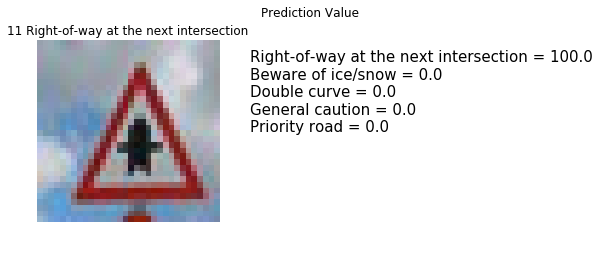

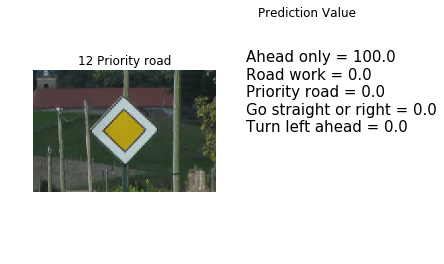

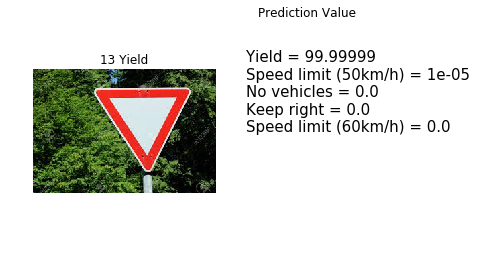

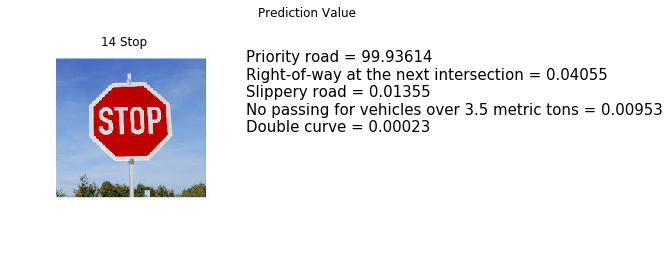

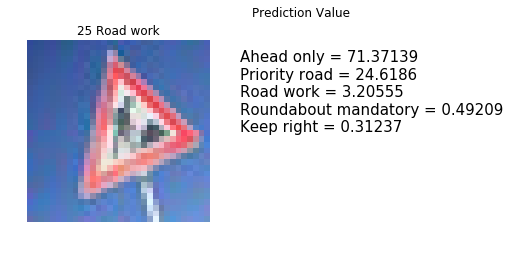

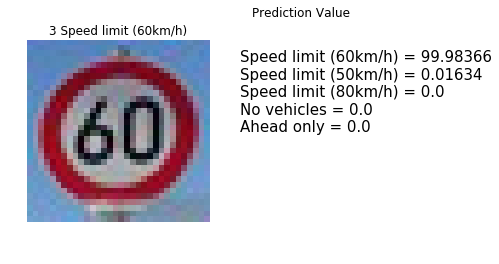

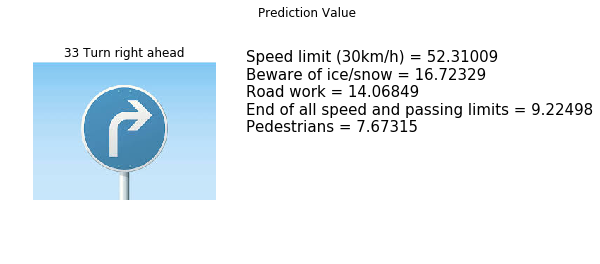

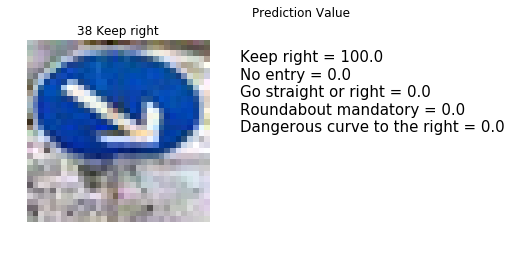

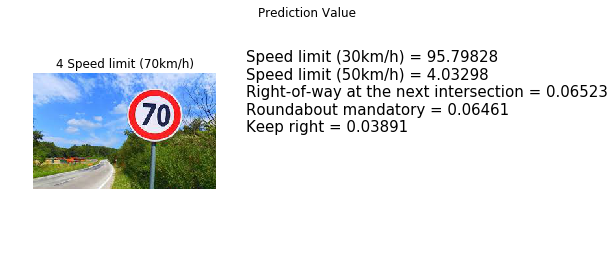

In [21]:
import matplotlib.pyplot as plt

for j in range(len(x_new)):
    fig,ax=plt.subplots(nrows=1,ncols=2,gridspec_kw={'width_ratios':[3,2]})
    
    tot=sum(op[0][j])
    percentage=[i*100/tot for i in op[0][j]]
    
    ax[0].axis('off')
    ax[0].set_title(str(y_new[j]) + " " + SignNames[int(y_new[j])+1])
    ax[0].imshow(test_image[j])
    ax[1].axis('off')
    ax[1].set_title("Prediction Value")
    
    ans=sorted(summary[j],key=summary[j].get,reverse=True)
    desc=""
    for k in range(len(ans)):
        desc=desc+"\n"+ans[k]+" = "+str(round(summary[j][ans[k]],5))
    ax[1].text(0,0.5,desc,fontsize=15)


In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    Train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(Train_accuracy*100))
    Valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.3f}".format(Valid_accuracy*100))
    Test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(Test_accuracy*100))

Train Accuracy = 99.569
Valid Accuracy = 95.215
Test Accuracy = 93.658
